In [165]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [166]:
scene = "lego"
suffix = "all_100"
base_dir = f"/home/ccl/Code/svox2/opt/ckpt_auto/128_to_256_scannerf/{suffix}/{scene}/test_renders"
c2ws = np.load(f"{base_dir}/c2ws.npy")


c2ws = np.load(f"{base_dir}/c2ws.npy")

center_pt = np.mean(c2ws[:,:3,3], axis=0)
# directions_train = (c2ws_train[:,:3,3] - center_pt)
directions = (c2ws[:,:3,3] - center_pt)
# directions_train = directions_train / np.linalg.norm(directions_train, keepdims=True, axis=1)
directions = directions / np.linalg.norm(directions, keepdims=True, axis=1)
# cos_dist = np.matmul(directions, directions_train.transpose())
# closest_train_index = np.argmax(cos_dist, axis=1)
# cos_dist = np.max(cos_dist, axis=1)
# angles = np.arccos(cos_dist)
abs_angles = np.arctan2(directions[:,0], directions[:,2])

def get_metrics(base_dir):
    psnr = np.load(f"{base_dir}/psnr.npy")
    psnr_train = np.load(f"{base_dir}/psnr.npy")
    return psnr, psnr_train
    
# suffixes = ["all_100", "all_250", "all_500", "all"]
suffixes = ["all_100","all"]
c2ws_train = []
psnrs = []
psnrs_train = []

for suffix in suffixes:
    base_dir2 = f"/home/ccl/Code/svox2/opt/ckpt_auto/128_to_256_scannerf/{suffix}/{scene}/test_renders"

    c2ws_train.append(np.load(f"{base_dir2}/c2ws_train.npy"))
    psnr, psnr_train = get_metrics(base_dir2)
    psnrs.append(psnr)
    psnrs_train.append(psnr_train)

psnrs = np.stack(psnrs)
psnrs_train = np.stack(psnrs_train)
best_psnr = np.max(psnrs, axis=0)
best_psnr_idx = np.argmax(psnrs, axis=0)

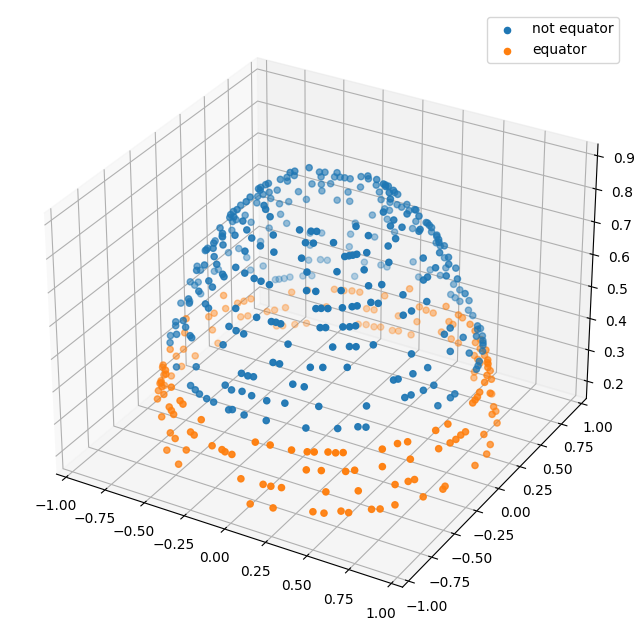

In [167]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
equator_threshold = -0.4
equator = np.where(c2ws[:,1,3] > equator_threshold)
not_equator = np.where(c2ws[:,1,3] < equator_threshold)
ax.scatter(c2ws[not_equator,0,3],c2ws[not_equator,2,3],-c2ws[not_equator,1,3], label="not equator")
ax.scatter(c2ws[equator,0,3],c2ws[equator,2,3],-c2ws[equator,1,3], label="equator")
ax.legend()
fig.savefig("/home/ccl/Downloads/plots/EQUATOR_FILTER.jpeg")

psnr_filtered = psnrs[:,equator][:,0,:]
c2ws_filtered = c2ws[equator]
abs_angles_filtered = abs_angles[equator]
angles_filtered = angles[equator]

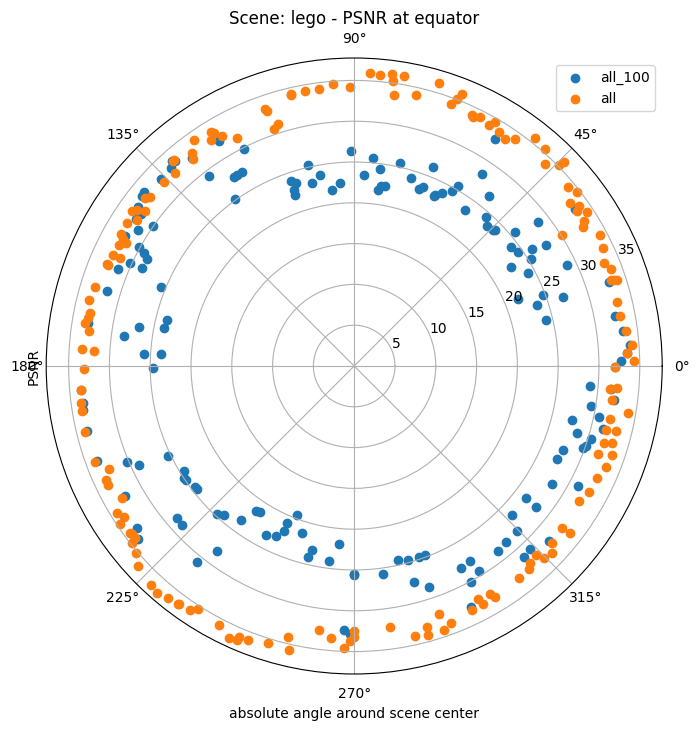

In [168]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
ax = fig.add_subplot(projection='polar')
plt.ylabel("PSNR")
plt.xlabel("absolute angle around scene center")
plt.title(f"Scene: {scene} - PSNR at equator")
x = abs_angles_filtered
for i, suffix in enumerate(suffixes):
    y = psnr_filtered[i]
    idx = np.argsort(x)
    # ax.plot(x[idx], y[0,idx], label=f"{suffix}")
    ax.scatter(x, y, label=f"{suffix}")

ax.legend()
fig.savefig(f"/home/ccl/Downloads/plots/{scene}_psnr_equator.jpeg")


In [169]:
fail_idx = np.argsort(psnr_filtered, axis=1)[:,:8]
success_idx = np.argsort(psnr_filtered, axis=1)[:,-8:]

In [170]:
def vis_sample(img_id, desc):
    fig = plt.figure(figsize=(10,8))
    ax1 = plt.subplot(211, projection='polar')
    ax2 = plt.subplot(212)
    
    ax1.title.set_text(f"{desc} - img_id {img_id}")
    for j, suffix in enumerate(suffixes):
        ax1.scatter(abs_angles_filtered, psnr_filtered[j], s=5, label=suffix)
    ax1.scatter([abs_angles[img_id]], psnrs[0,img_id], s=100, label=f"current")
    
    
    img_path = os.path.join(base_dir, f'{img_id:04d}.png')
    img = np.asarray(Image.open(img_path))
    ax2.title.set_text(f"{desc} - PSNR: {psnrs[0,img_id]:.2f}")
    ax2.imshow(img)
    
    fig.savefig(f"/home/ccl/Downloads/plots/{scene}_{desc}_{psnrs[0,img_id]:.03f}_{img_id}.png")
    


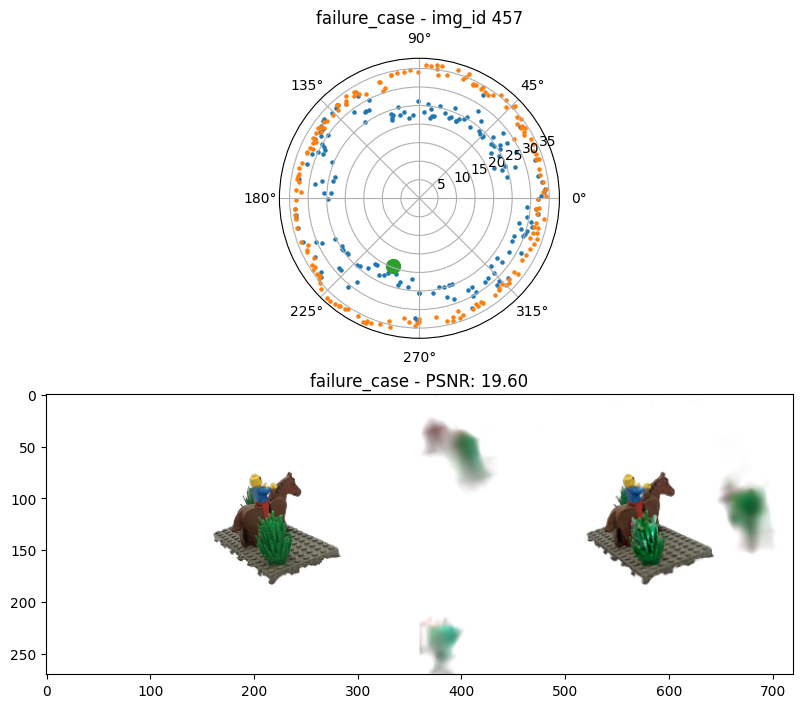

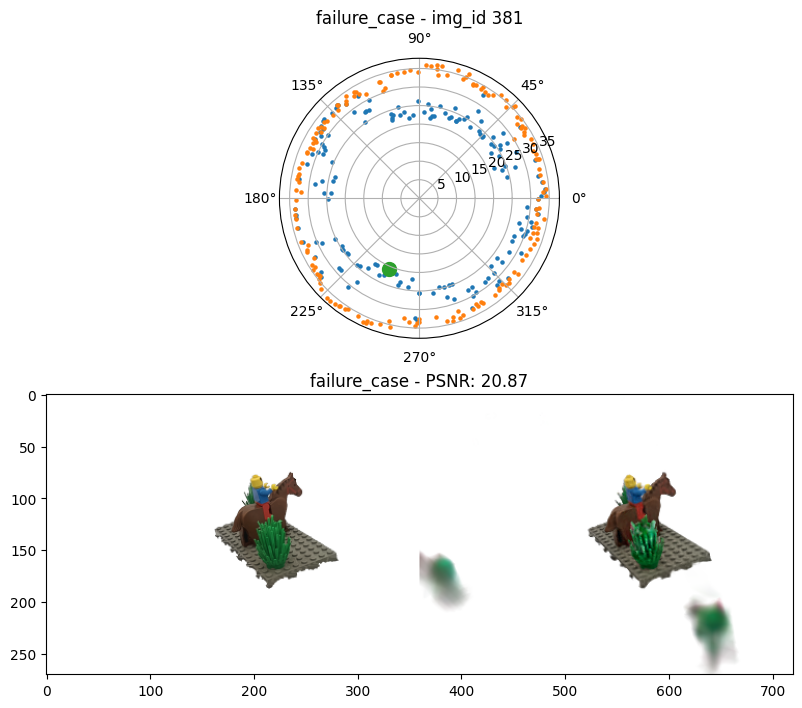

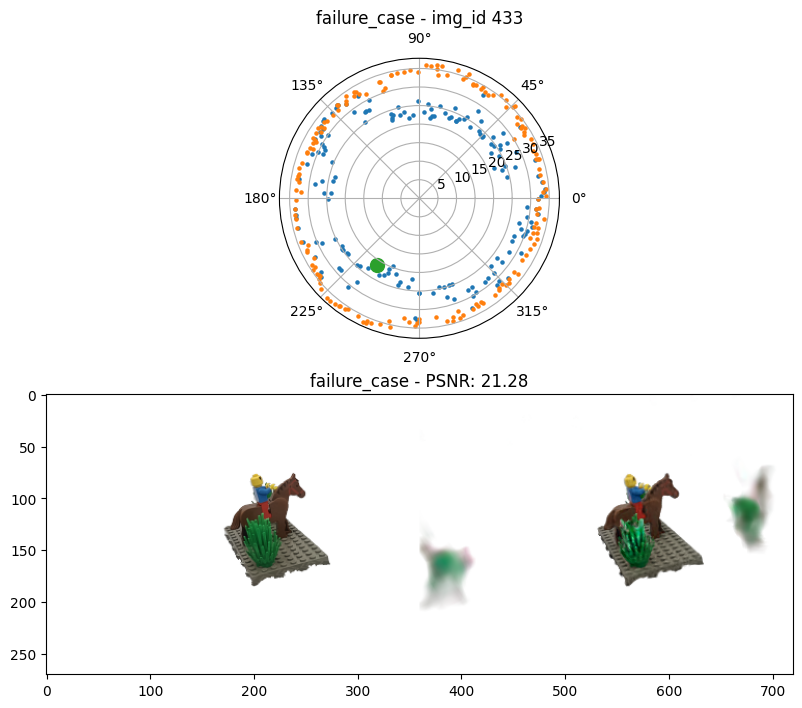

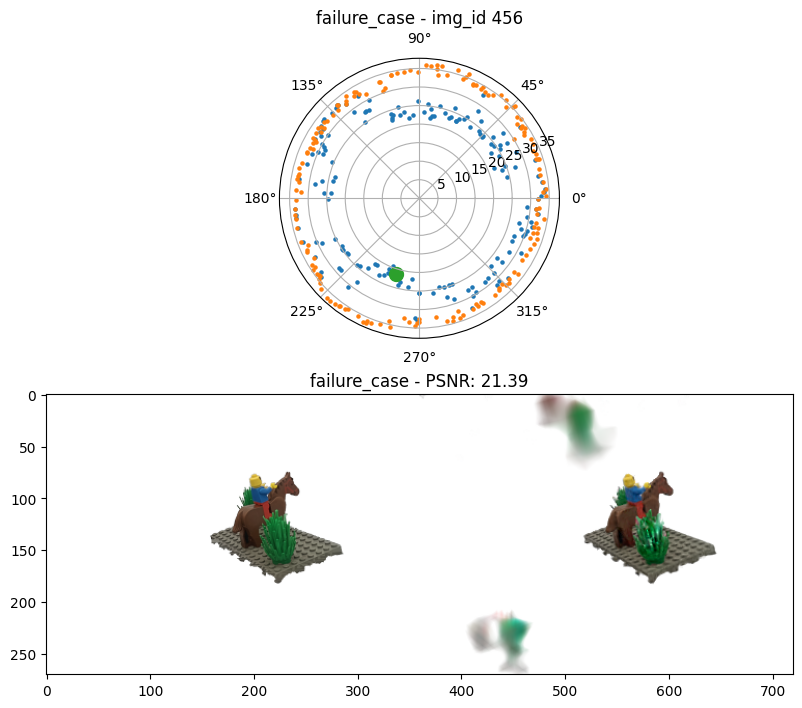

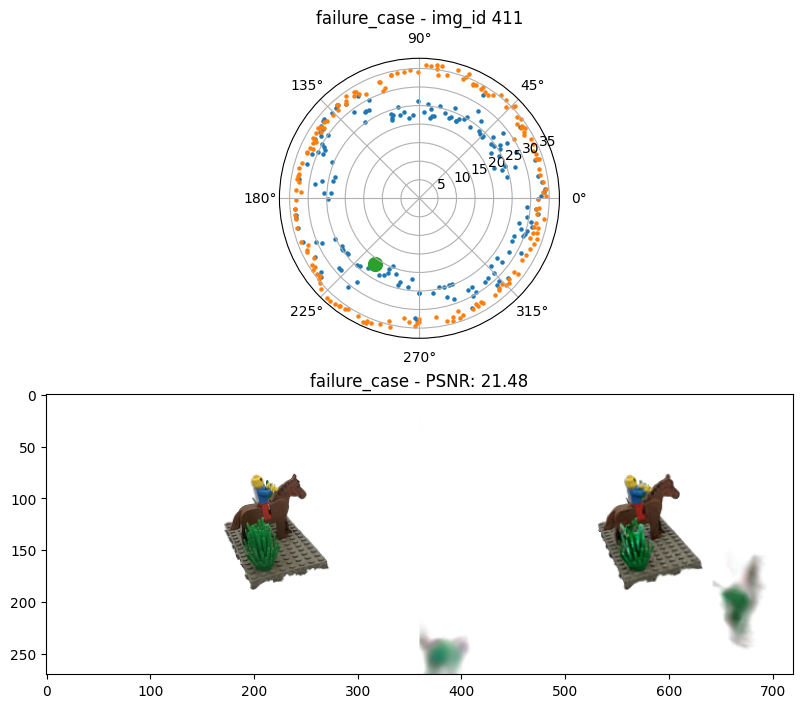

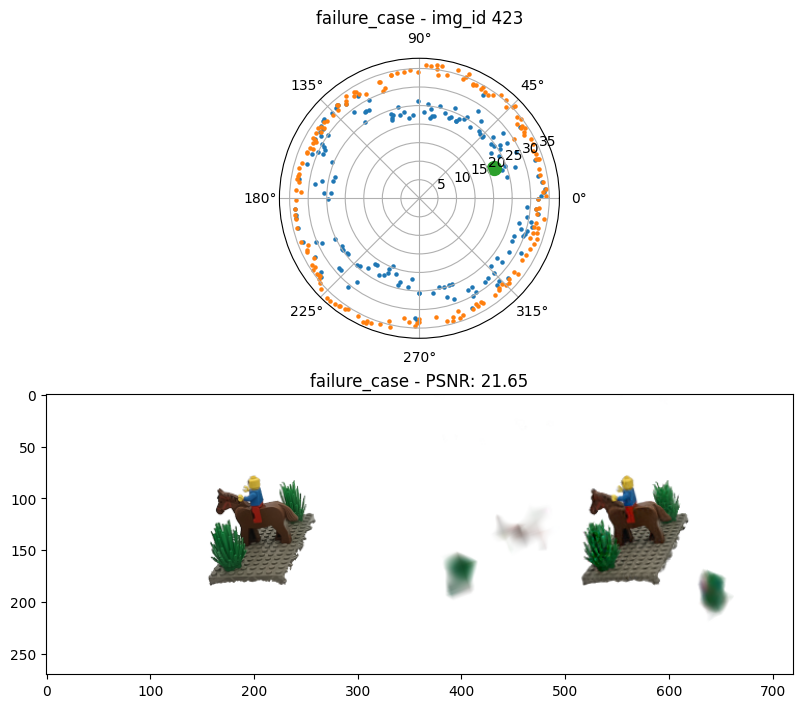

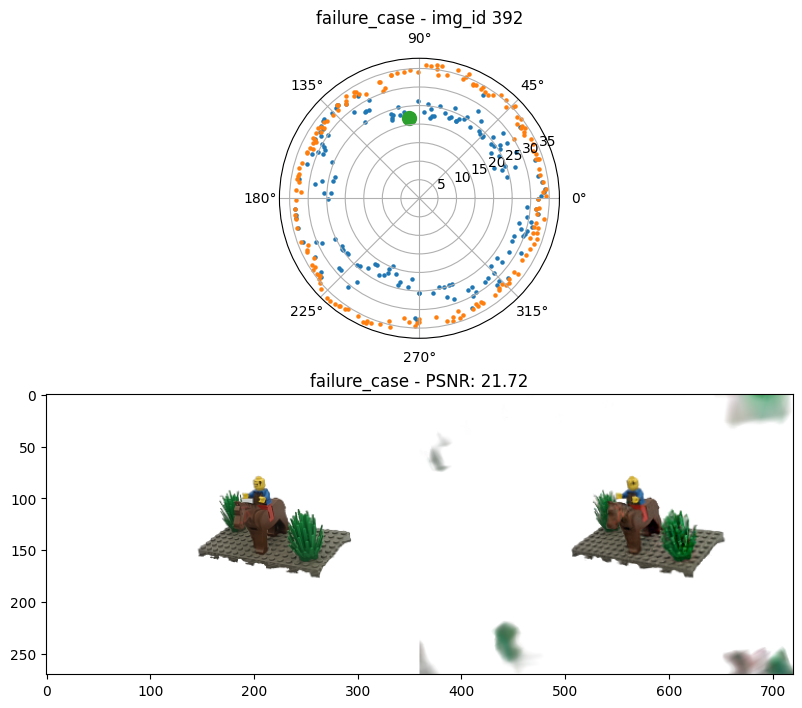

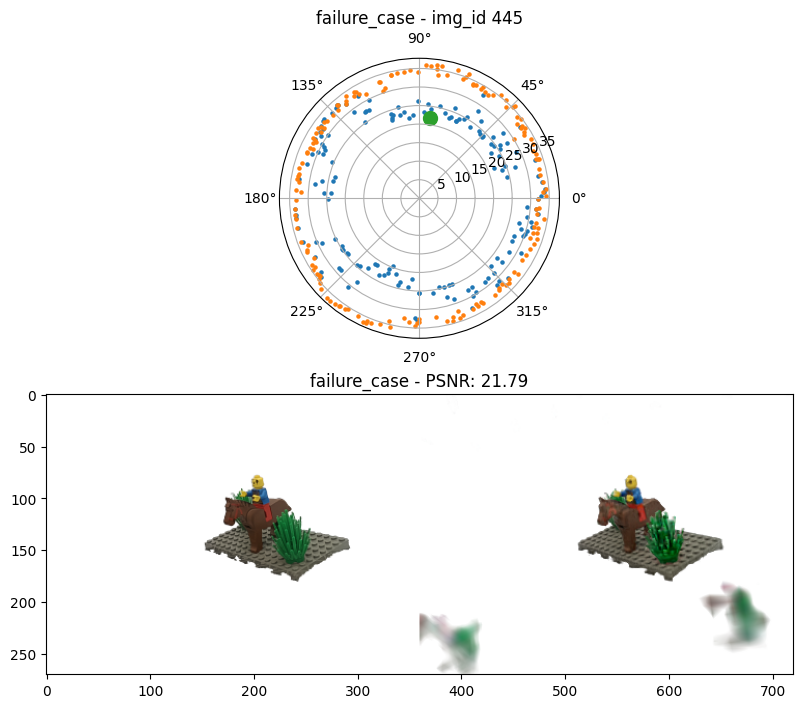

In [171]:

for img_id in list(equator[0][fail_idx][0,:]):
    vis_sample(img_id, "failure_case")

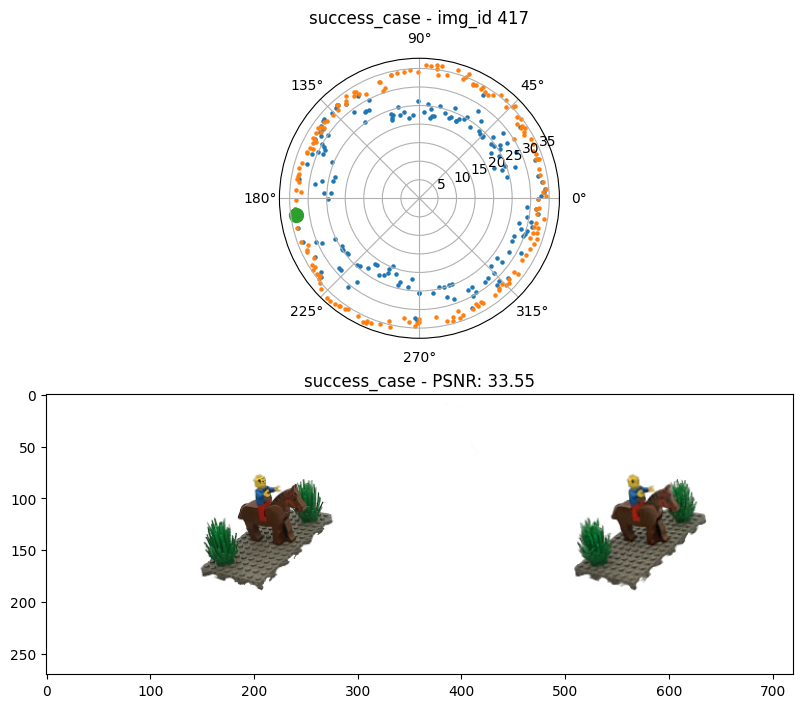

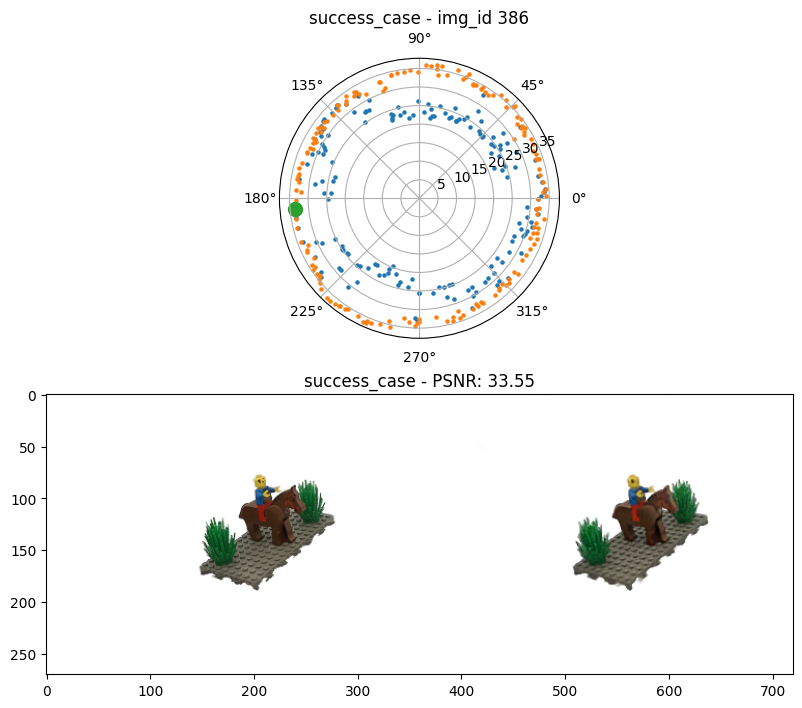

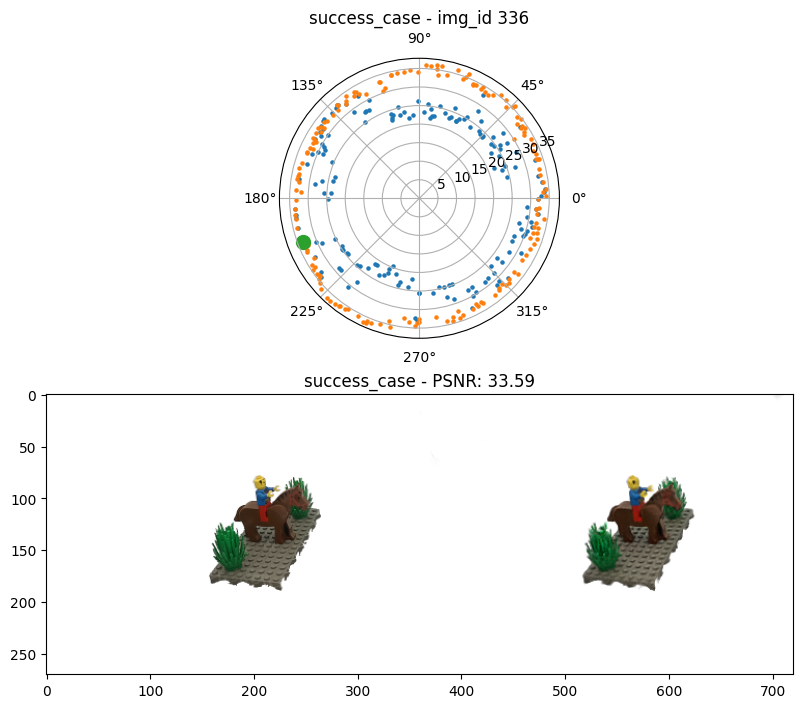

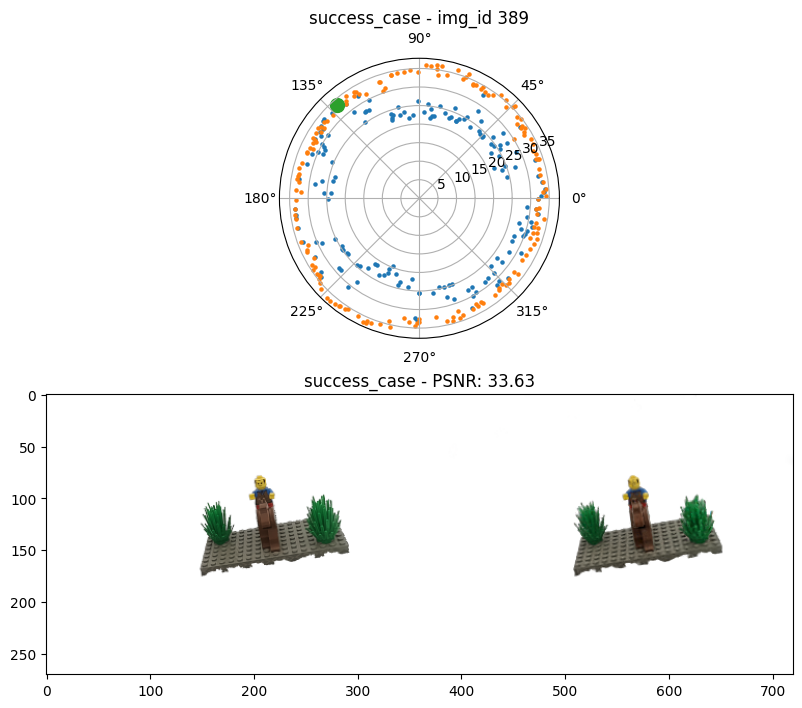

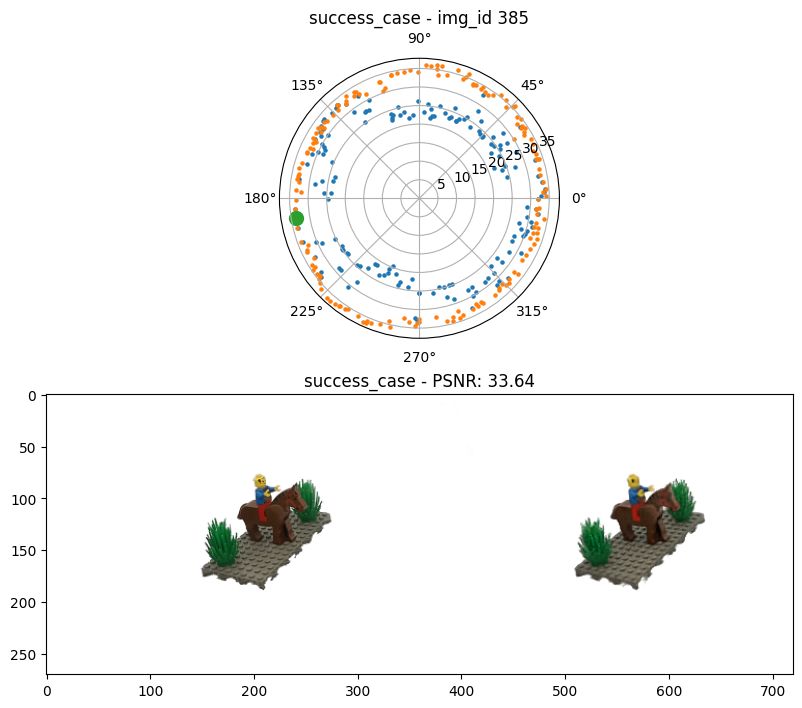

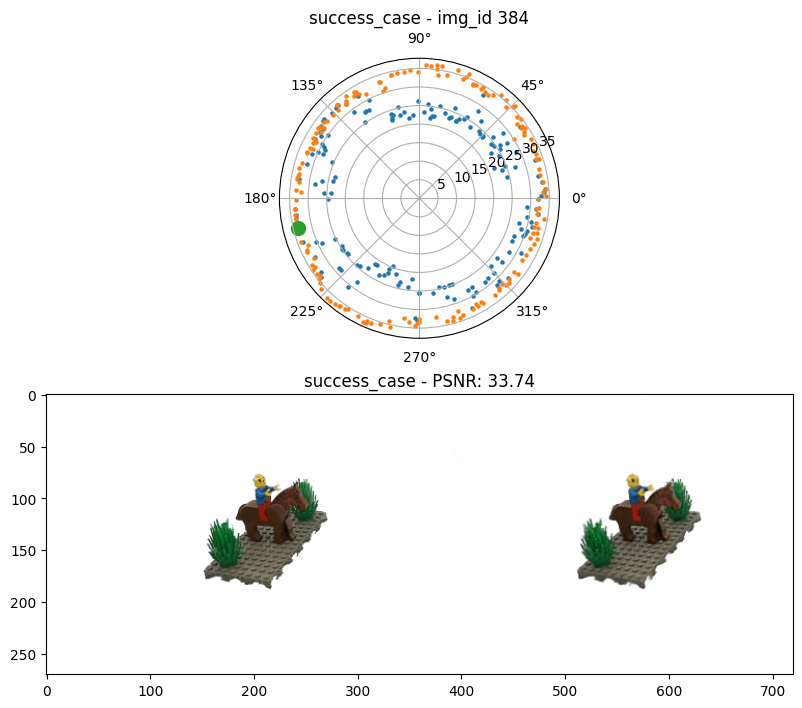

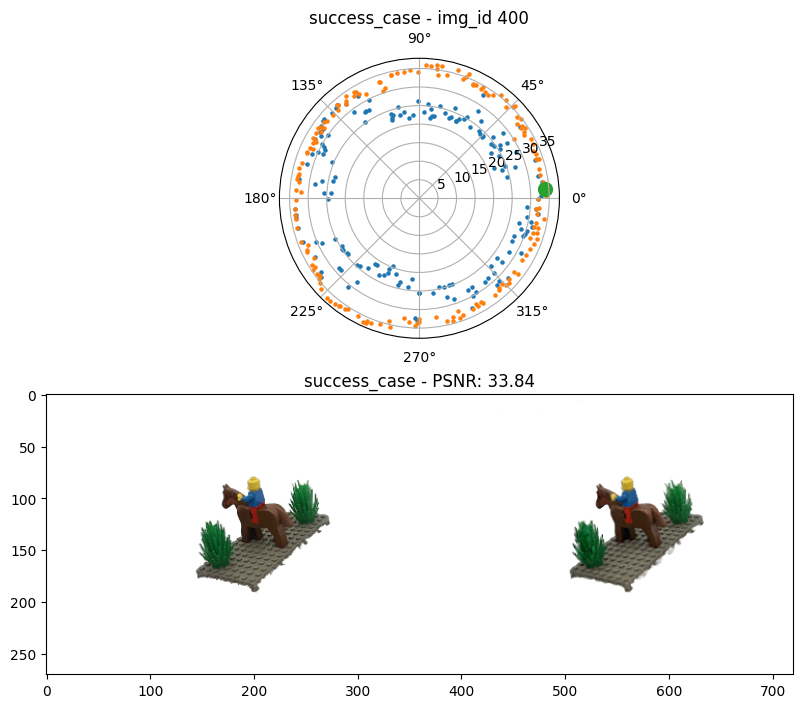

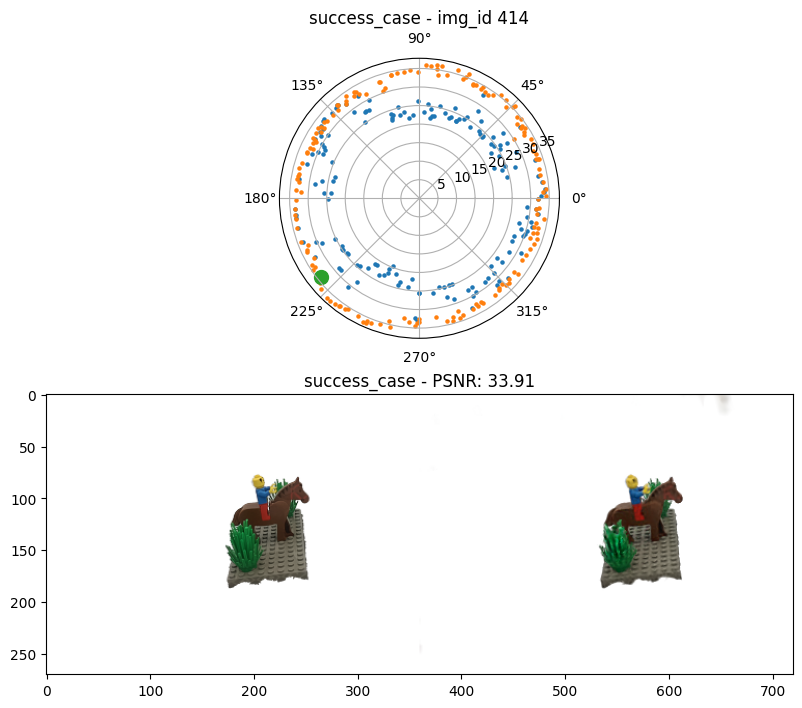

In [172]:

for img_id in list(equator[0][success_idx][0,:]):
    vis_sample(img_id, "success_case")
    

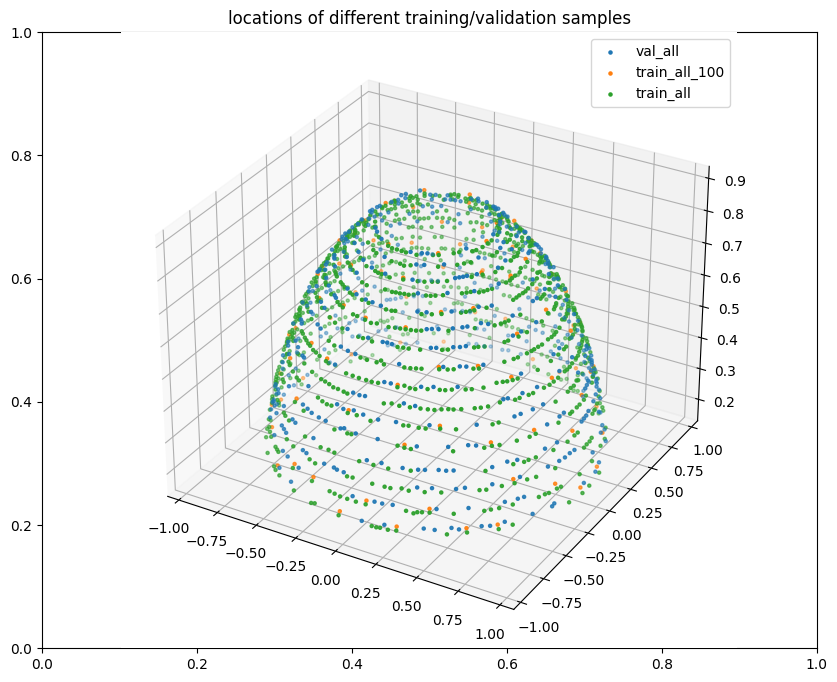

In [173]:

fig = plt.figure(figsize=(10,8))
plt.title("locations of different training/validation samples")
ax = fig.add_subplot(projection='3d')

ax.scatter(c2ws[:,0,3],c2ws[:,2,3],-c2ws[:,1,3], s=5, label="val_all")
for i, suffix in enumerate(suffixes):
    # plt.title(f"train locations {suffix}")
    ax.scatter(c2ws_train[i][:,0,3],c2ws_train[i][:,2,3],-c2ws_train[i][:,1,3], s=5, label=f"train_{suffix}")

ax.legend()
fig.savefig("/home/ccl/Downloads/plots/{scene}_sample_locations.jpeg")